<a href="https://colab.research.google.com/github/maxhof905/se_corpus/blob/main/task/scripts/pt_pytorch_active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch active learning loop: Portuguese

maxhof905


sources :
- https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
- https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/#step-2-make-dataset-iterable

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) Imports

In [2]:
# installations for colab
!pip install skorch
!pip install modal


     |████████████████████████████████| 155 kB 11.4 MB/s 


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling


## 2) helper functions

In [4]:
def get_class_dist(df_col):
    """
    plot label distribution
    """
    data = df_col.value_counts(normalize=True).rename('percentage').mul(100).reset_index().rename(columns = {"index":"label"})
    plot = sns.barplot(x="label", y="percentage", data=data)
    plot.set_xticklabels(plot.get_xticklabels(),
                          rotation=90,
                          horizontalalignment='right')
    

In [5]:
def get_balanced_set(df):
    """
    create balanced data set (oversampling)
    """
    max_size = df['se_label'].value_counts().max()
    balanced_list = [df]
    for class_index, group in df.groupby('se_label'):
        balanced_list.append(group.sample(max_size-len(group), replace=True))
    return pd.concat(balanced_list)


In [6]:
def get_flattened_list(nested_list):
    return [item for sublist in nested_list for item in sublist]


In [7]:
def get_learners_preds(prediction_proba):
    """
    return the learners predictions as a dict with labels as keys and the probabilities as values
    :param prediction_proba: values obtained from learner.predict()
    :return: dict with probability per label
    """
    prediction_proba = np.round(prediction_proba, 2)
    prediction_list = list()
    for i in range(len(prediction_proba)):
        predictions = {'expl': prediction_proba[i][0], 'fixed': prediction_proba[i][1],
                      'iobj': prediction_proba[i][2], 'mark': prediction_proba[i][3], 
                       'nsubj': prediction_proba[i][4], 'obj': prediction_proba[i][5]}
        prediction_list.append(predictions)
    return prediction_list


## 3) load and preprocess data
- initial_train: labeled test set ('seed')
- pool: pool of unlabeled data
- test: small labeled test set


In [8]:
train_path = 'https://raw.githubusercontent.com/maxhof905/se_corpus/main/ud/pt_data/pt_bosque-ud-train.txt'
test_path = 'https://raw.githubusercontent.com/maxhof905/se_corpus/main/ud/pt_data/pt_bosque-ud-test.txt'
dev_path = 'https://raw.githubusercontent.com/maxhof905/se_corpus/main/ud/pt_data/pt_bosque-ud-dev.txt'
pool_path = 'https://raw.githubusercontent.com/maxhof905/se_corpus/main/corpusdata_org/pt_text_se_corpus.txt'

train = pd.read_csv(train_path, sep='\t', names=['text', 'tokenized_text', 'se_label'])
train.drop(columns=['text'], inplace = True)
dev = pd.read_csv(dev_path, sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
dev.drop(columns=['text'], inplace = True)
test = pd.read_csv(test_path, sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
test.drop(columns=['text'], inplace = True)

se_corpus = pd.concat([train, dev, test]) # because the data was fileted for 'se' the data splits are not reliable anymore
se_corpus = se_corpus.drop(se_corpus[(se_corpus['se_label'] == 'case')].index)
se_corpus = se_corpus.drop(se_corpus[(se_corpus['se_label'] == 'nmod')].index)
se_corpus = se_corpus.drop(se_corpus[(se_corpus['se_label'] == 'expl:pass')].index)

pool = pd.read_csv(pool_path, sep='\t', names=['text'])



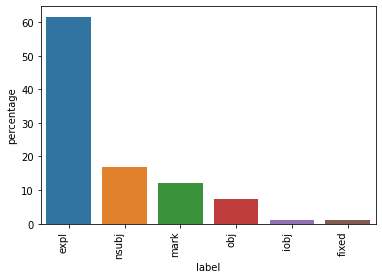

In [9]:
get_class_dist(se_corpus.se_label)


In [10]:
X = se_corpus.tokenized_text
y = se_corpus.se_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2022)


In [11]:
label_encoder = preprocessing.LabelEncoder()
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

pool_vectorized = vectorizer.transform(pool.text).toarray()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


In [12]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)


In [13]:
class PoolDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data

    def __getitem__(self, index):
        return self.X_data[index]

    def __len__(self):
        return len(self.X_data)
    

In [14]:
train_set = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
test_set = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

pool_set = PoolDataset(torch.from_numpy(pool_vectorized).float())


In [15]:
train_features = torch.reshape(train_set.X_data,   (train_set.X_data.shape[0], 1,train_set.X_data.shape[1]))
train_labels = train_set.y_data


In [16]:
test_features = torch.reshape(test_set.X_data,   (test_set.X_data.shape[0], 1,test_set.X_data.shape[1]))
test_labels = test_set.y_data


In [17]:
train_features.shape[2]

7342

In [18]:
X_pool = pool_set.X_data
X_pool = torch.reshape(X_pool,   (X_pool.shape[0], 1, X_pool.shape[1]))
X_pool = X_pool.detach().cpu().numpy()


## 4) Model

In [19]:
label_encoder.classes_

array(['expl', 'fixed', 'iobj', 'mark', 'nsubj', 'obj'], dtype=object)

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim=64):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = 1
        # batch_first=True causes input/output tensors to be of shape
        # tensor shape: (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(train_features.shape[2], hidden_dim, 1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 6) #equals the number of label encoder classes

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    

In [21]:
# skorch library creates sklearn classifier from torch neural net
# infer initial parameters from es_pytorch_active_learning (which was run first with extensive GridSearch)

# create the classifier
device = "cuda" if torch.cuda.is_available() else "cpu"
print('using: ', device)

# Callbacks: print accuracy when model is fitted
acc = EpochScoring(scoring='accuracy', on_train=True,
                         name='accuracy', lower_is_better=False)

f1 = EpochScoring(scoring='f1_weighted', on_train=True,
                         name='f1-score', lower_is_better=False)

callbacks = [acc, f1]

classifier = NeuralNetClassifier(module=LSTMModel,
                                 batch_size=64,
                                 max_epochs= 10,
                                 criterion=nn.CrossEntropyLoss,
                                 optimizer=torch.optim.Adam,
                                 lr=0.001,
                                 train_split=None,
                                 callbacks=callbacks,
                                 verbose=1,
                                 device=device)


using:  cuda


In [ ]:
classifier.fit(train_features, train_labels)


  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.4410      0.4070        1.7037  0.0756
      2      0.6170      0.4719        1.5089  0.0606
      3      0.6160      0.4696        1.2841  0.0637
      4      0.6160      0.4696        1.0947  0.0706
      5      0.6160      0.4696        0.9596  0.0626
      6      0.6430      0.5258        0.8239  0.0606
      7      0.7530      0.7026        0.6775  0.0591
      8      0.8570      0.8374        0.5317  0.0585
      9      0.9190      0.9081        0.4043  0.0600
     10      0.9480      0.9410        0.3048  0.0606


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LSTMModel(
    (lstm): LSTM(7342, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=6, bias=True)
  ),
)

***model is overfitting***: 
Run hyperparameter for best parameter setting

In [ ]:
# infer suited parameters from es_pytorch_active_learning and run smaller hyperparameter search
from sklearn.model_selection import GridSearchCV

params = {
    'max_epochs': [10],
    'batch_size':[32, 64],
    'lr': [0.001, 0.01],
    'module__hidden_dim': [64, 128],
}
gs = GridSearchCV(classifier, params, refit=False, cv=5, scoring='accuracy')

gs.fit(train_features, train_labels)


  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5175      0.4404        1.6780  0.0804
      2      0.6162      0.4699        1.3630  0.0802
      3      0.6162      0.4699        1.1085  0.0799
      4      0.6175      0.4728        0.9461  0.0801
      5      0.6713      0.5723        0.7750  0.0813
      6      0.8137      0.7685        0.5885  0.0797
      7      0.9038      0.8803        0.4217  0.0927
      8      0.9500      0.9444        0.2963  0.0806
      9      0.9762      0.9751        0.2098  0.0785
     10      0.9900      0.9897        0.1522  0.0799
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.3725      0.3917        1.7347  0.0773
      2      0.6225      0.4857        1.3882  0.0804
      3      0.6162      0.4699        1.1065  0.0792
      4      0.6188      0.4756        0.9477  0.0795
      5      0.6675      0.5

GridSearchCV(cv=5,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LSTMModel(
    (lstm): LSTM(7342, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=6, bias=True)
  ),
),
             param_grid={'batch_size': [32, 64], 'lr': [0.001, 0.01],
                         'max_epochs': [10], 'module__hidden_dim': [64, 128]},
             refit=False, scoring='accuracy')

In [ ]:
print('\ngs.best_score_ ', gs.best_score_, '\ngs.best_params_', gs.best_params_)



gs.best_score_  0.634 
gs.best_params_ {'batch_size': 32, 'lr': 0.001, 'max_epochs': 10, 'module__hidden_dim': 128}


In [22]:
# refit with optimal parameters

classifier = NeuralNetClassifier(module=LSTMModel,
                                 module__hidden_dim = 128,
                                 batch_size=32,
                                 max_epochs= 10,
                                 criterion=nn.CrossEntropyLoss,
                                 optimizer=torch.optim.Adam,
                                 lr=0.001,
                                 train_split=None,
                                 callbacks=callbacks,
                                 #callbacks__train_loss=None,
                                 verbose=1,
                                 device=device)

classifier.fit(train_features, train_labels)


  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5560      0.4617        1.5997  0.2511
      2      0.6160      0.4696        1.1570  0.1454
      3      0.6220      0.4830        0.9302  0.1431
      4      0.7490      0.6929        0.6672  0.1378
      5      0.9060      0.8892        0.3954  0.1343
      6      0.9640      0.9611        0.2204  0.1378
      7      0.9810      0.9801        0.1317  0.1399
      8      0.9900      0.9898        0.0859  0.1381
      9      0.9940      0.9939        0.0601  0.1344
     10      0.9970      0.9970        0.0443  0.1448


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LSTMModel(
    (lstm): LSTM(7342, 128, batch_first=True)
    (fc): Linear(in_features=128, out_features=6, bias=True)
  ),
)

In [23]:
from sklearn.metrics import classification_report

targets = label_encoder.classes_

y_pred_test = classifier.predict(test_features)
print(classification_report(test_labels, y_pred_test, target_names=targets, zero_division=0))


              precision    recall  f1-score   support

        expl       0.66      0.96      0.78       155
       fixed       0.00      0.00      0.00         2
        iobj       0.00      0.00      0.00         2
        mark       1.00      0.16      0.28        31
       nsubj       0.29      0.14      0.19        43
         obj       0.00      0.00      0.00        18

    accuracy                           0.64       251
   macro avg       0.32      0.21      0.21       251
weighted avg       0.58      0.64      0.55       251



## 5) Active Learner

In [24]:
train_features = train_features.detach().cpu().numpy()
train_labels = train_labels.detach().cpu().numpy()

In [25]:
# no training arguments because classifier is already fitted
learner = ActiveLearner(estimator=classifier,
                        query_strategy=uncertainty_sampling,
                        X_training=train_features,
                        y_training=train_labels,
                        )


Re-initializing module because the following parameters were re-set: hidden_dim.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    accuracy    f1-score    train_loss     dur
-------  ----------  ----------  ------------  ------
      1      0.5600      0.4687        1.5879  0.4224
      2      0.6160      0.4696        1.1448  0.2715
      3      0.6190      0.4764        0.9251  0.2392
      4      0.7570      0.7040        0.6647  0.2498
      5      0.9020      0.8869        0.3986  0.2574
      6      0.9600      0.9565        0.2260  0.2672
      7      0.9840      0.9833        0.1358  0.1897
      8      0.9910      0.9908        0.0885  0.2122
      9      0.9940      0.9939        0.0618  0.1946
     10      0.9970      0.9970        0.0455  0.2144


In [26]:
number_of_loops = 10
n_instances = 20
accuracies = [learner.score(test_features, test_labels)] # append first accuracy without learning
pool_sent_list= list() # store annotated sentences and the labels
pool_label_list= list()


### Loop
- stops after 20 iterations
- prompt sentence

Problem: if annotation is 'None' (e.g in the case a sentence is discarded) the loop breaks. We have to discard certain sentences because when creating the underlying corpus
phrases that do not contain 'se' like 'aunque a tu mac no le pase nada' were not discarded because there is no suited programmatical way to differentiate btw. 'pase' and 'siéntese'.

In [27]:
for i in range(number_of_loops):

    # query new instances
    query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)
    predicted_proba = get_learners_preds(learner.predict_proba(X_pool[query_idx]))
    sentences = pool.text.iloc[query_idx]

    # annotate the queried instances
    annotation = list()
    counter = 0
    for sent, proba in zip(sentences, predicted_proba):
        counter += 1
        sorted_proba = sorted(proba.items(), key=lambda kv: kv[1], reverse=True)
        prompt = '\n'+'loop: '+str(i+1)+'\n'+'sentence: '+str(counter)+'\n'+'The learners predictions are:'+'\n'+str(sorted_proba)+'\n\n'+sent+'\n'
        label = str(input(prompt))
        annotation.append(label)

    # keep track of annotations
    sent_list = sentences.to_list()
    pool_sent_list.append(sent_list)
    pool_label_list.append(annotation)

    # filter out sentences that were assigned 'None'; the learner should not see them
    if 'None' in annotation:
        print('Note: you either discarded samples or did not annotate all samples')
        discarded_idxs=[idx for idx, sample in enumerate(annotation) if sample == 'None'] # TODO
        discarded_idxs = sorted(discarded_idxs, reverse=True)
        for index in discarded_idxs:
            query_inst = np.delete(query_inst, index, axis=0)
        annotation = list(filter('None'.__ne__, annotation))


    # teach the learner
    y_pool = label_encoder.transform(annotation)
    learner.teach(query_inst, y_pool)
    accuracies.append(learner.score(X=test_features, y=test_labels))

    # delete queried instances from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    


loop: 1
sentence: 1
The learners predictions are:
[('expl', 0.25), ('mark', 0.23), ('nsubj', 0.21), ('obj', 0.19), ('fixed', 0.06), ('iobj', 0.06)]

tornaram se prisioneiros esperando para acontecer .
iobj

loop: 1
sentence: 2
The learners predictions are:
[('expl', 0.22), ('fixed', 0.21), ('nsubj', 0.18), ('mark', 0.15), ('obj', 0.14), ('iobj', 0.09)]

Ou pior , vender como se fosse uma guitarra de luthier fabricada a mão .
fixed

loop: 1
sentence: 3
The learners predictions are:
[('nsubj', 0.23), ('expl', 0.22), ('obj', 0.22), ('mark', 0.21), ('fixed', 0.06), ('iobj', 0.06)]

EU penso que a essas temperaturas se chama estado sub-febril .
expl

loop: 1
sentence: 4
The learners predictions are:
[('mark', 0.24), ('expl', 0.22), ('nsubj', 0.22), ('obj', 0.19), ('iobj', 0.07), ('fixed', 0.06)]

Informe o seu médico ou farmacêutico se estiver a tomar outros medicamentos .
mark

loop: 1
sentence: 5
The learners predictions are:
[('expl', 0.24), ('obj', 0.21), ('nsubj', 0.2), ('mark', 0.19)

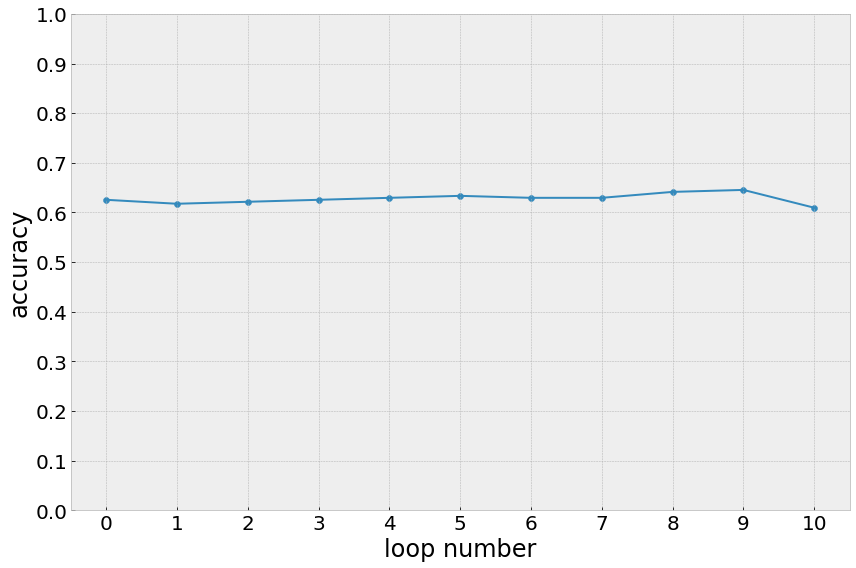

In [33]:
# plot learning curve
with plt.style.context('bmh'):
    csfont = {'fontname':'Times New Roman'}
    plt.figure(figsize=(12, 8))
    plt.plot(range(number_of_loops+1), accuracies)
    plt.scatter(range(number_of_loops+1), accuracies)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=20, **csfont)
    plt.xticks(np.arange(0, 11, 1), fontsize=20, **csfont)
    plt.xlabel('loop number',fontsize=24, **csfont)
    plt.ylabel('accuracy',fontsize=24, **csfont)
    plt.savefig('/plots/pt_pytorch.png')
    plt.tight_layout()
    plt.show()
    
    

In [30]:
max(accuracies)


0.6454183266932271

In [31]:
# create df from annotations
sent_flattened = get_flattened_list(pool_sent_list)
label_flattened = get_flattened_list(pool_label_list)

labeled_pool = pd.DataFrame(list(zip(sent_flattened, label_flattened)),
               columns =['text', 'se_label'])
print(labeled_pool.shape)
print(labeled_pool.head())


(200, 2)
                                                text se_label
0  tornaram se prisioneiros esperando para aconte...     iobj
1  Ou pior , vender como se fosse uma guitarra de...    fixed
2  EU penso que a essas temperaturas se chama est...     expl
3  Informe o seu médico ou farmacêutico se estive...     mark
4  Eh um motivador pessoal para se estudar guitar...    nsubj


In [34]:
# save labeled pool
labeled_pool.to_csv('/labeled_data/pt_pytorch_annotations.txt', header=None, index=False,  sep='\t')
